# **Amazon Review Polarity Dataset**

Los datos contienen 34.686.770 reseñas de Amazon de 6,643,669 usuarios sobre 2.441.053 productos, del Proyecto de Análisis de Redes de Stanford (SNAP). Este subconjunto contiene 1,800,000 muestras de entrenamiento y 200,000 muestras de prueba para cada sentimiento de polaridad.

Los archivos CSV (df_train y df_test) contienen las columnas: polaridad, título y texto. Estas tres columnas corresponden al índice de clase (1 o 2), el título de la reseña y el cuerpo de la reseña.

* **Polaridad:** 1 para negativa y 2 para positiva
* **Título:** encabezado de la reseña
* **Texto:** cuerpo de la reseña

Fuente: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews/data



In [1]:
!pip install vaderSentiment
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [21]:
# Líbrerias
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme(style='whitegrid')
palette='viridis'
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **1. Cargar y Revisión de la Estructura de los Datos**
Cargamos el dataset de reseñas de Amazon en df_train y df_test, verificando que contenga tres columnas: polaridad (1 o 2), titulo, y texto.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")

print("Path to dataset files:", path)

100%|██████████| 1.29G/1.29G [00:20<00:00, 67.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kritanjalijain/amazon-reviews/versions/2


In [4]:
# Lista los archivos en el directorio de destino
files = os.listdir(path)
print("Archivos descargados:", files)

# Definir los nombres de las columnas
column_names = ['polaridad', 'titulo', 'texto']

# Cargar el archivo 'train.csv'
train_file = os.path.join(path, 'train.csv')
df_train = pd.read_csv(train_file, names=column_names)
print("Primeras filas del archivo 'train.csv':")
print(df_train.head(10))

# Cargar el archivo 'test.csv'
test_file = os.path.join(path, 'test.csv')
df_test = pd.read_csv(test_file, names=column_names)
print("\nPrimeras filas del archivo 'test.csv':")
print(df_test.head(10))



Archivos descargados: ['test.csv', 'train.csv', 'amazon_review_polarity_csv.tgz']
Primeras filas del archivo 'train.csv':
   polaridad                                             titulo  \
0          2                     Stuning even for the non-gamer   
1          2              The best soundtrack ever to anything.   
2          2                                           Amazing!   
3          2                               Excellent Soundtrack   
4          2  Remember, Pull Your Jaw Off The Floor After He...   
5          2                            an absolute masterpiece   
6          1                                       Buyer beware   
7          2                                     Glorious story   
8          2                                   A FIVE STAR BOOK   
9          2                      Whispers of the Wicked Saints   

                                               texto  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of review

In [5]:
# Información de la data de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   polaridad  int64 
 1   titulo     object
 2   texto      object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


### **2. Tratamiento de Datos Faltantes**

Si encontramos valores nulos en la columna texto, decido eliminarlos porque es probable que estos datos no aporten valor para el análisis de sentimiento.

In [6]:
# Datos faltantes
print(df_train.isnull().sum())
print(df_test.isnull().sum())

polaridad      0
titulo       207
texto          0
dtype: int64
polaridad     0
titulo       24
texto         0
dtype: int64


In [7]:
# Agregar nombres de columnas
df_train.head()

,polaridad,titulo,texto
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


# **Preprocesamiento de texto**
Por mi capacidad computacional realizo los análisis posteriores con solo 100000 muestras de train y 10000 de test, este paso en la computación de AWS no sería necesario

In [8]:
# Muestra
df_train = df_train.head(100000)
df_test = df_test.head(10000)

print(df_train['polaridad'].value_counts())
print(df_test['polaridad'].value_counts())

polaridad
2    51267
1    48733
Name: count, dtype: int64
polaridad
2    5125
1    4875
Name: count, dtype: int64


### **3. Unión de las Columnas texto**

In [9]:
# Unir el titulo con el texto
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'texto', 'titulo', 'texto')
df_test = concat_columns(df_test, 'texto', 'titulo', 'texto')

### **4. Conversión y Normalización de la Etiqueta de polaridad**

La columna polaridad se convierte de valores 1 (negativa) y 2 (positiva) a valores binarios 0 (negativa) y 1 (positiva).

In [10]:
# Cambio la polaridad a 0=1 (negativa) y 1=2 (positiva)
df_train['polaridad'] = df_train['polaridad'].map({1:0, 2:1})
df_test['polaridad'] = df_test['polaridad'].map({1:0, 2:1})

### **5. Limpieza de Texto**
Llevo a cabo la limpieza del texto, eliminando caracteres especiales como signos de puntuación, símbolos y números irrelevantes para asegurar que el modelo no se vea influenciado por el ruido. Además, estadandarizo el texto aplicando técnicas como la conversión a minúsculas y la eliminación de espacios adicionales.

### **6. Tokenización del Texto**
El preprocesamiento involucra la tokenización del texto, donde el contenido se segmenta en palabras individuales (tokens). Esto es importante para el análisis posterior, ya que permite manejar cada palabra por separado en lugar de tratar el texto como un bloque único. La tokenización también facilita la conversión de palabras a representaciones numéricas, un paso necesario para entrenar modelos de machine learning y deep learning.
### **8. Aplicación de Stemming o Lematización**

Se aplica otras técnicas de preprocesamiento, como la eliminación de palabras vacías (palabras comunes que aportan poco significado, como "el", "y", "de"), el stemming o lematización (reducir las palabras a sus formas raíz), y la creación de n-gramas para capturar combinaciones de palabras.

In [11]:
# Tokeniza el texto y elimina palabras comunes (stopwords) que no aportan significado.
stop_words = stopwords.words('english') # Descargar stopwords en ingles

# Función para limpiar el texto eliminando URLs, menciones y signos de puntuación
def clean_text(text):
    if isinstance(text, str):
        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar URLs (enlaces http, https y www)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Eliminar enlaces en formato markdown [texto](enlace)
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        # Eliminar menciones (@usuario)
        text = re.sub(r'@\w+', '', text)

        # Eliminar signos de puntuación y caracteres especiales
        text = text.translate(str.maketrans('', '', string.punctuation))

        return text
    else:
        return text

# Función para tokenizar el texto en palabras individuales
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

# Función para eliminar las palabras vacías (stopwords) del texto tokenizado
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in stop_words]
    else:
        return tokens

# Función para aplicar stemming a los tokens
def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    else:
        return tokens

### Aplicar las funciones al DataFrame
# Limpiar el texto
df_train['texto_limpio'] = df_train['texto'].apply(clean_text)
df_test['texto_limpio'] = df_test['texto'].apply(clean_text)

# Tokenizar el texto limpio
df_train['tokens'] = df_train['texto_limpio'].apply(tokenize_text)
df_test['tokens'] = df_test['texto_limpio'].apply(tokenize_text)

# Aplicar stemming a las palabras tokenizadas
df_train['stemmed_texto'] = df_train['tokens'].apply(stem_tokens)
df_test['stemmed_texto'] = df_test['tokens'].apply(stem_tokens)

# Eliminar palabras vacías del texto tokenizado
df_train['sin_stopwords_texto'] = df_train['tokens'].apply(remove_stopwords)
df_test['sin_stopwords_texto'] = df_test['tokens'].apply(remove_stopwords)

# Mostrar las primeras filas del DataFrame para visualizar el conjunto de datos
df_train.head()


,polaridad,texto,texto_limpio,tokens,stemmed_texto,sin_stopwords_texto
0,1,This sound track was beautiful! It paints the ...,this sound track was beautiful it paints the s...,"[this, sound, track, was, beautiful, it, paint...","[thi, sound, track, wa, beauti, it, paint, the...","[sound, track, beautiful, paints, senery, mind..."
1,1,I'm reading a lot of reviews saying that this ...,im reading a lot of reviews saying that this i...,"[im, reading, a, lot, of, reviews, saying, tha...","[im, read, a, lot, of, review, say, that, thi,...","[im, reading, lot, reviews, saying, best, game..."
2,1,This soundtrack is my favorite music of all ti...,this soundtrack is my favorite music of all ti...,"[this, soundtrack, is, my, favorite, music, of...","[thi, soundtrack, is, my, favorit, music, of, ...","[soundtrack, favorite, music, time, hands, int..."
3,1,I truly like this soundtrack and I enjoy video...,i truly like this soundtrack and i enjoy video...,"[i, truly, like, this, soundtrack, and, i, enj...","[i, truli, like, thi, soundtrack, and, i, enjo...","[truly, like, soundtrack, enjoy, video, game, ..."
4,1,"If you've played the game, you know how divine...",if youve played the game you know how divine t...,"[if, youve, played, the, game, you, know, how,...","[if, youv, play, the, game, you, know, how, di...","[youve, played, game, know, divine, music, eve..."


### **9. Vectorización del Texto**
Realizo un top de las palabras mas frecuentes para observar que es lo que los usuarios mas mencionan.

In [12]:
# Crear el vectorizador de palabras
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=stop_words)

# Crear la matriz de términos y documentos
dtm = vectorizer.fit_transform(df_train['texto'])

# Crear el modelo LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Mostrar los temas principales
for index, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print("\n")


Top 10 words for topic #0
['best', 'love', 'good', 'songs', 'great', 'one', 'music', 'like', 'album', 'cd']


Top 10 words for topic #1
['see', 'great', 'really', 'bad', 'time', 'good', 'like', 'film', 'one', 'movie']


Top 10 words for topic #2
['quality', 'bought', 'get', 'use', 'dvd', 'good', 'would', 'product', 'great', 'one']


Top 10 words for topic #3
['like', 'love', 'reading', 'books', 'life', 'great', 'one', 'story', 'read', 'book']


Top 10 words for topic #4
['great', 'get', 'like', 'reading', 'books', 'one', 'would', 'good', 'read', 'book']




En general, parece que el vocabulario indica que los usuarios tienden a tener una valoración positiva de los productos, resaltando aspectos de calidad, disfrute y apreciación.

### **10. Diccionario de palabras mas frecuentes**
A continuación, creo un DataFrame que asocia cada palabra con su frecuencia total. Ordeno este DataFrame en orden descendente para identificar las palabras más comunes, y finalmente, configuro un diccionario con algunas de las palabras mas comunes, les agrego un puntaje "compound" con calificaciones que el diccionario de VADER maneja para las palabras postivas, negativas y neutrales.

In [13]:
# Obtener el nombre de las palabras (feature names)
feature_names = vectorizer.get_feature_names_out()

# Sumar las frecuencias de las palabras en la matriz dtm
word_freq = np.asarray(dtm.sum(axis=0)).flatten()

# Crear un DataFrame con las palabras y sus frecuencias
word_freq_df = pd.DataFrame({'word': feature_names, 'frequency': word_freq})

# Ordenar el DataFrame por frecuencia en orden descendente
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Diccionario de palabras mas frecuentes
# Definir conjuntos de palabras comúnmente positivas y negativas en inglés para una asignación genérica
positive_words = {"good", "great", "excellent", "amazing", "love", "best", "wonderful", "superb", "fantastic", "happy"}
negative_words = {"bad", "terrible", "poor", "worst", "awful", "hate", "horrible", "disappointing", "sad", "failure"}
neutral_words = {"book", "movie", "one", "make", "time", "will", "see", "get", "like", "know", "read"}

# Función para asignar una puntuación genérica basada en palabras comunes positivas y negativas
def generic_score(word):
    if word in positive_words:
        return 0.75  # Positiva
    elif word in negative_words:
        return -0.75  # Negativa
    elif word in neutral_words:
        return 0.0  # Neutral
    else:
        return 0.0  # Neutral

# Aplicar la función para asignar puntuaciones
word_freq_df['score'] = word_freq_df['word'].apply(generic_score)

# Mostrar el DataFrame actualizado con las columnas de palabra, frecuencia y puntuación
word_freq_df[['word', 'frequency', 'score']].head(10)

,word,frequency,score
6085,book,62066,0.00
32011,one,40732,0.00
30139,movie,31333,0.00
20296,great,30377,0.75
19969,good,30334,0.75
26728,like,30148,0.00
36913,read,25335,0.00
50941,would,22936,0.00
46274,time,20105,0.00
19512,get,18584,0.00


### **11. Distribución de Sentimiento**

Genero una visualización gráfica para analizar la distribución de cantidades en función de las categorías de sentimiento.

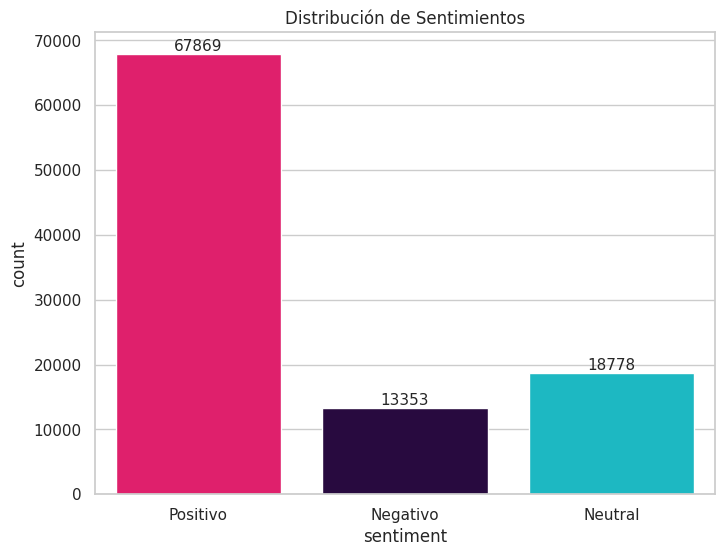

In [14]:
# Inicializar el analizador de sentimientos
sid = SentimentIntensityAnalyzer()

# Crear el diccionario con las palabras más frecuentes y sus puntuaciones
word_sentiment_dict = dict(zip(word_freq_df['word'], word_freq_df['score']))

# Actualizar el lexicon de VADER con las puntuaciones manuales de las palabras más frecuentes
sid.lexicon.update(word_sentiment_dict)

# Función para clasificar el sentimiento basado en el puntaje 'compound'
def classify_sentiment(score):
    if score > 0.01:
        return 'Positivo'
    elif score < -0.01:
        return 'Negativo'
    else:
        return 'Neutral'

# Aplicar el análisis de sentimientos a cada comentario
df_train['compound'] = df_train['texto_limpio'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_train['sentiment'] = df_train['compound'].apply(classify_sentiment)

# Visualizar la distribución de sentimientos con etiquetas de conteo sobre cada barra
plt.figure(figsize=(8, 6))
plot = sns.countplot(x='sentiment', data=df_train, palette=['#ff0066', '#290148', '#01d1dd'])
plt.title('Distribución de Sentimientos')

# Agregar etiquetas de conteo encima de cada barra
for p in plot.patches:
    plot.annotate(f'{int(p.get_height())}',
                  (p.get_x() + p.get_width() / 2, p.get_height()),
                  ha='center', va='bottom', fontsize=11)

plt.show()

El gráfico muestra que los usuarios suelen tener una percepción positiva, pero también hay un número considerable de opiniones neutras y negativas que podrían merecer atención para mejorar la experiencia general.

### **12. WordClouds**
Creo una lista de palabras neutrales para así tener una nueva columna en los datos que contiene el texto limpio, es decir, sin stopwords y sin estas palabras. Luego, separo el texto en función del sentimiento asignado (positivo, negativo o neutral) y combino todas las palabras correspondientes a cada categoría de sentimiento en un solo bloque de texto. Con estos bloques, genero tres nubes de palabras (WordClouds), una para cada tipo de sentimiento, y las visualizo en una figura con tres subgráficos. Cada nube de palabras resalta visualmente las palabras más frecuentes asociadas con los sentimientos positivos, negativos y neutrales en los comentarios analizados.

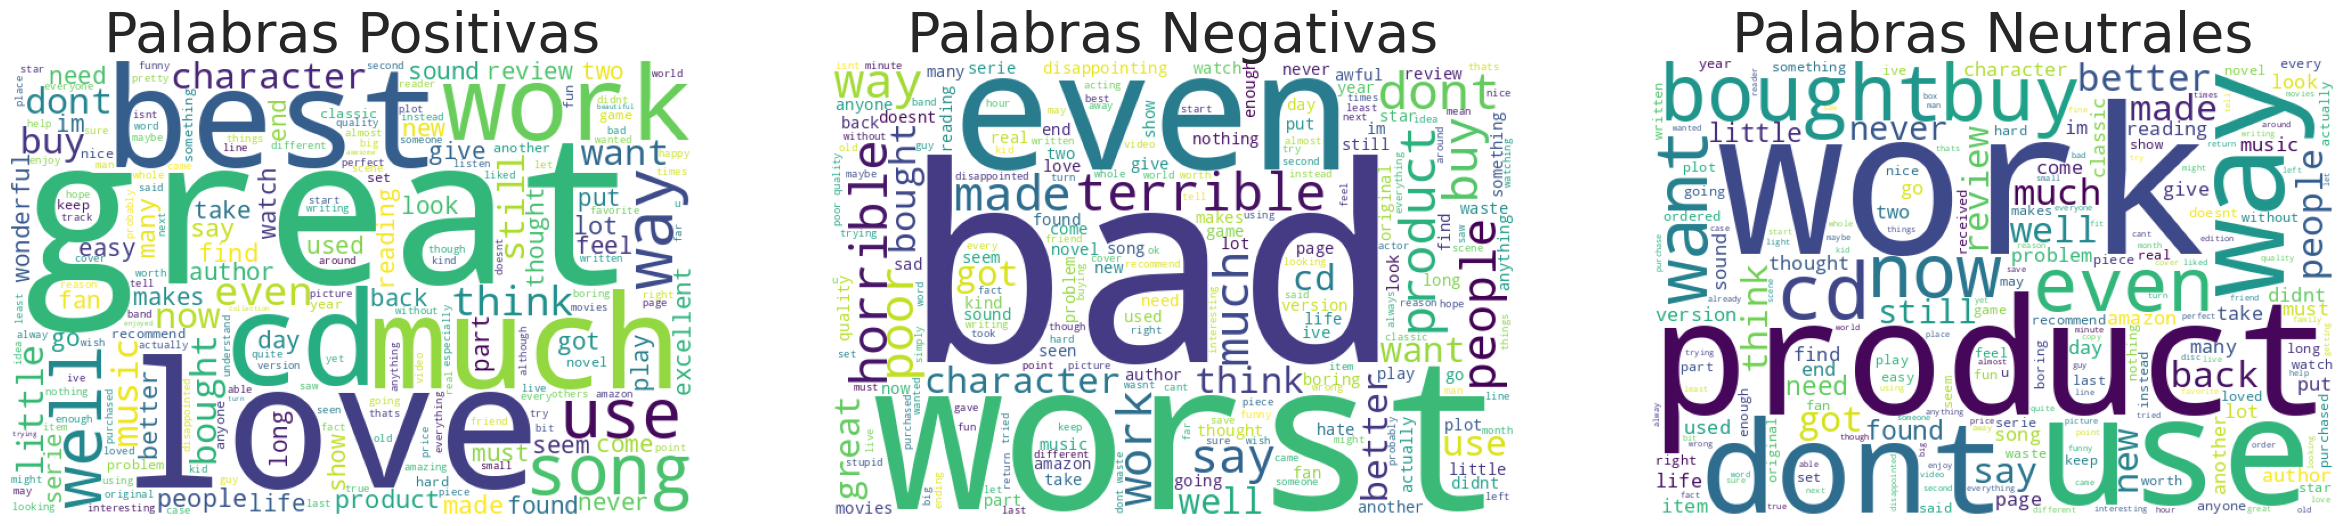

In [17]:
# Crear una lista de palabras comunes que se deben eliminar
common_words = {"book", "movie", "one", "make", "good", "time", "will", "see", "get", "like", "know","read","film","money","first","really","books","album","story","thing","dvd"}

# Crear una columna con el texto limpio, es decir, sin stopwords y palabras comunes
#df_train['texto_limpio'] = df_train['tokens'].apply(lambda x: ' '.join(x))
df_train['texto_limpio'] = df_train['tokens'].apply(lambda x: ' '.join([word for word in x if word not in common_words]))

# Separar las palabras según su sentimiento
positive_text = " ".join(df_train[df_train['sentiment'] == 'Positivo']['texto_limpio'])
negative_text = " ".join(df_train[df_train['sentiment'] == 'Negativo']['texto_limpio'])
neutral_text = " ".join(df_train[df_train['sentiment'] == 'Neutral']['texto_limpio'])

# Crear los WordClouds
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud(background_color='white', width=600, height=400).generate(positive_text)
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Palabras Positivas', fontsize=40)

wordcloud2 = WordCloud(background_color='white', width=600, height=400).generate(negative_text)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Palabras Negativas', fontsize=40)

wordcloud3 = WordCloud(background_color='white', width=600, height=400).generate(neutral_text)
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Palabras Neutrales', fontsize=40)

plt.show()


**Palabras Positivas:** Estas palabras indican que los usuarios destacan aspectos positivos con términos como "best", "great", y "love", lo que sugiere una experiencia altamente satisfactoria con el producto o servicio.

**Palabras Negativas:** Las reseñas negativas incluyen palabras que reflejan una fuerte insatisfacción, como "bad", "worst" y "terrible". Esto muestra una reacción emocional negativa y puede estar asociado con experiencias insatisfactorias o problemas específicos con el producto o servicio.

**Palabras Neutrales:** Las reseñas neutras se centran en palabras prácticas y de uso común, como "use", "product" y "work". Esto sugiere que estos comentarios podrían describir el producto de forma objetiva o simplemente explicar su uso sin mostrar una emoción clara.

### **12. WordClouds**

Genero unos gráficos de bigramas de palabras donde se muestra las combinaciones de dos palabras que más se repiten en los comentarios.

In [18]:
# Función para obtener los n-gramas más comunes
def get_top_n_gram(corpus, ngram_range, n=None):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtener brigramas para cada sentimiento
pos_bigrams = get_top_n_gram(df_train[df_train['sentiment'] == 'Positivo']['texto_limpio'], (2, 2), 20)
neg_bigrams = get_top_n_gram(df_train[df_train['sentiment'] == 'Negativo']['texto_limpio'], (2, 2), 20)
neutral_bigrams = get_top_n_gram(df_train[df_train['sentiment'] == 'Neutral']['texto_limpio'], (2, 2), 20)

# Convertir los brigramas en DataFrames
df_pos_trigrams = pd.DataFrame(pos_bigrams, columns=['texto', 'conteo'])
df_neg_trigrams = pd.DataFrame(neg_bigrams, columns=['texto', 'conteo'])
df_neutral_trigrams = pd.DataFrame(neutral_bigrams, columns=['texto', 'conteo'])

# Graficar los brigramas positivos
fig1 = px.bar(df_pos_trigrams, x='conteo', y='texto', orientation='h',
              title='Los 20 Brigramas Principales en Texto Positivo', color_discrete_sequence=['#ff0066'])
fig1.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='conteo', yaxis_title='texto')
fig1.show()

# Graficar los brigramas negativos
fig2 = px.bar(df_neg_trigrams, x='conteo', y='texto', orientation='h',
              title='Los 20 Brigramas Principales en Texto Negativo', color_discrete_sequence=['#290148'])
fig2.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='conteo', yaxis_title='texto')
fig2.show()

# Graficar los brigramas neutrales
fig3 = px.bar(df_neutral_trigrams, x='conteo', y='texto', orientation='h',
              title='Los 20 Brigramas Principales en Texto Neutral', color_discrete_sequence=['#01d1dd'])
fig3.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='conteo', yaxis_title='texto')
fig3.show()

A partir de este gráfico se pueden extraer las siguientes conclusiones para las áreas de mejora:

* **Calidad del Producto:** Los bigramas más frecuentes incluyen "poor quality" (mala calidad) y "sound quality" (calidad de sonido), lo que sugiere que muchos de los comentarios negativos están relacionados con la percepción de baja calidad en los productos, especialmente en aspectos específicos como el sonido.

* **Desperdicio de Dinero:** Bigrama como "dont waste" (no desperdicies) y "dont buy" (no compres) indican que los usuarios desaconsejan la compra del producto, percibiéndolo como una pérdida de dinero. Esto es un fuerte indicador de insatisfacción con el valor percibido.

* **Experiencias Extremadamente Negativas:** Términos como "worst ever" (el peor de todos) y "really bad" (realmente malo) muestran que algunos usuarios clasifican su experiencia con términos muy negativos, posiblemente comparándola desfavorablemente con otras experiencias.

* **Aspectos Específicos del Producto o Servicio:** Bigrama como "special effects" (efectos especiales) y "customer service" (servicio al cliente) sugieren que hay áreas específicas del producto o servicio que generan frustración entre los usuarios. Esto podría apuntar a problemas con la calidad de los efectos en productos audiovisuales o con el servicio de atención al cliente.

* **Quejas sobre Durabilidad o Edad del Producto:** Bigramas como "year old" (año de antigüedad) y "years ago" (hace años) podrían indicar que los usuarios mencionan problemas relacionados con la durabilidad o antigüedad del producto, lo que es otra causa de insatisfacción.

Estas conclusiones sugieren que los aspectos de calidad, servicio al cliente y valor percibido son áreas clave de mejora para reducir la insatisfacción de los clientes y mejorar su experiencia general.

### **13. Modelamiento**

Entrenar múltiples modelos, incluyendo tres modelos tradicionales de machine learning (como Regresión Logística, Árbol de Decisión y AdaBoost) junto con una red neuronal en TensorFlow, permite evaluar el rendimiento de diferentes enfoques sin requerir una gran capacidad computacional. Los modelos tradicionales son relativamente ligeros y rápidos de entrenar, proporcionando buenos resultados en problemas de clasificación de texto sin requerir infraestructura de hardware avanzada. Por otro lado, la red neuronal en TensorFlow añade una capa de complejidad y puede capturar patrones más profundos en los datos, pero sigue siendo un modelo sencillo con pocas capas y parámetros optimizados, por lo que no demanda excesiva capacidad computacional. Esta combinación permite comparar enfoques y seleccionar el mejor modelo para el problema, sin necesidad de grandes recursos de cómputo.

Model 1: LogisticRegression
Training Accuracy: 0.8704
Testing Accuracy: 0.8662

Confusion Matrix for Model 1: LogisticRegression 

 [[4152  723]
 [ 615 4510]]


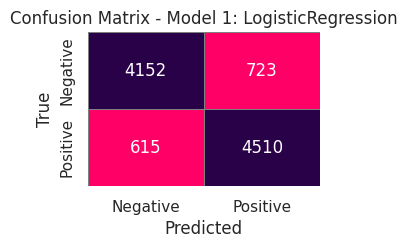

-----------------
Model 2: DecisionTreeClassifier
Training Accuracy: 0.6889
Testing Accuracy: 0.6868

Confusion Matrix for Model 2: DecisionTreeClassifier 

 [[2780 2095]
 [1037 4088]]


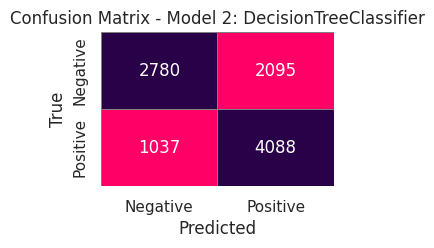

-----------------
Model 3: AdaBoostClassifier
Training Accuracy: 0.7161
Testing Accuracy: 0.7180

Confusion Matrix for Model 3: AdaBoostClassifier 

 [[2926 1949]
 [ 871 4254]]


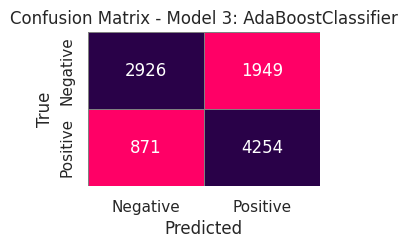

-----------------


In [19]:
# Definir etiquetas para los gráficos de la matriz de confusión
labels = ['Negative', 'Positive']

# Crear un colormap personalizado con los colores especificados y blanco
custom_cmap = ListedColormap(['#ff0066', '#290148'])#, '#01d1dd'

# 1. Convertir el texto en características numéricas con TF-IDF (Reducido a 1,000)
tfidf = TfidfVectorizer(max_features=1000)
X_train = tfidf.fit_transform(df_train['texto_limpio'])
X_test = tfidf.transform(df_test['texto_limpio'])

# Definir las etiquetas (variable objetivo)
y_train = df_train['polaridad']
y_test = df_test['polaridad']

# 2. Lista de modelos ligeros
models = [
    LogisticRegression(random_state=50),
    DecisionTreeClassifier(random_state=42, max_depth=5),
    AdaBoostClassifier(n_estimators=10, random_state=45)
]

# 3. Evaluar cada modelo y mostrar la matriz de confusión
for i, model in enumerate(models):
    # Entrenar y predecir con el modelo
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcular precisión en entrenamiento y prueba
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Imprimir resultados de precisión
    print(f"Model {i+1}: {type(model).__name__}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print()

    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    print(f'Confusion Matrix for Model {i+1}: {type(model).__name__} \n\n', cm)

    # Graficar la matriz de confusión con el colormap personalizado
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap, cbar=False,
                xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Model {i+1}: {type(model).__name__}")
    plt.show()
    print("-----------------")




**Modelo 1: LogisticRegression**
* **Training Accuracy:** 87.04%
* **Testing Accuracy:** 86.62%
* **Analysis:** La regresión logística muestra un buen equilibrio entre la precisión en el conjunto de entrenamiento y el de prueba, con valores muy similares. Esto indica que el modelo se generaliza bien a datos nuevos sin presentar problemas de sobreajuste ni subajuste. Es un modelo efectivo y estable para este conjunto de datos.

**Model 2: DecisionTreeClassifier**
* **Training Accuracy:** 68.89%
* **Testing Accuracy:** 68.68%
* **Analysis:** El modelo de árbol de decisión tiene una precisión más baja en comparación con la regresión logística y el AdaBoost. La similitud entre la precisión en entrenamiento y prueba indica que el modelo no está sobreajustado, pero su capacidad predictiva es limitada, probablemente debido a la profundidad restringida del árbol. Este modelo podría beneficiarse de ajustes adicionales para mejorar su rendimiento.

**Model 3: AdaBoostClassifier**
* **Training Accuracy:** 71.61%
* **Testing Accuracy:** 71.80%
* **Analysis:** AdaBoost presenta un rendimiento ligeramente superior al del árbol de decisión solo, con una precisión moderada y una generalización aceptable. La similitud entre los valores de precisión en entrenamiento y prueba sugiere que el modelo no está sobreajustado, aunque su precisión es menor que la de la regresión logística. Esto indica que, aunque el modelo AdaBoost mejora ligeramente sobre el árbol de decisión, podría no ser la mejor opción entre los tres modelos evaluados para este conjunto de datos.

In [22]:
# Parámetros del preprocesamiento
max_words = 10000
max_len = 200

# Tokenización y preprocesamiento de texto
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['texto_limpio'])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['texto_limpio']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['texto_limpio']), maxlen=max_len)

y_train = df_train['polaridad'].values
y_test = df_test['polaridad'].values

# Configuración del modelo
embedding_dim = 16

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Construir el modelo explícitamente con una muestra de datos de entrada antes de mostrar el resumen
model.build(input_shape=(None, max_len))

# Ver resumen del modelo
model.summary()

# Configurar EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluar en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Obtener predicciones en el conjunto de prueba
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas adicionales
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6736 - loss: 0.5796 - val_accuracy: 0.8712 - val_loss: 0.3222
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8751 - loss: 0.3018 - val_accuracy: 0.8830 - val_loss: 0.2873
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8936 - loss: 0.2640 - val_accuracy: 0.8834 - val_loss: 0.2829
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9030 - loss: 0.2435 - val_accuracy: 0.8921 - val_loss: 0.2669
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9065 - loss: 0.2347 - val_accuracy: 0.8717 - val_loss: 0.3027
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9100 - loss: 0.2268 - val_accuracy: 0.8820 - val_loss: 0.2819
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9111 - loss: 0.2240 - val_accuracy: 0.8867 - val_loss: 0.2720
Test Accuracy: 0.8916
Test Loss: 0.2647
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Pr

Este modelo de red neuronal es relativamente ligero, con solo 160,289 parámetros, la mayoría de ellos en la capa de embedding. Este es adecuado para tareas de clasificación de texto.

* **Capa de Embedding**: para representar cada palabra como un vector de tamaño 16.
* **GlobalAveragePooling1D** para obtener un vector de representación promedio de las palabras en cada secuencia.
* **Capas Densas** para procesar la representación y realizar la clasificación final.

**Modelo: Red Neuronal en TensorFlow**

* **Precision:** 89.55%
* **Recall:** 88.49%
* **F1 Score:** 89.02%
* **Análisis:** La red neuronal en TensorFlow muestra un rendimiento alto y equilibrado, con valores sólidos de precisión y recall. La alta precisión (89.55%) indica que el modelo comete pocos errores al identificar la clase positiva, mientras que el recall (88.49%) muestra que también detecta la mayoría de los ejemplos positivos. El F1 Score de 89.02% confirma un buen balance entre precisión y recall, sugiriendo que el modelo es confiable para esta tarea de clasificación. En general, la red neuronal es efectiva y generaliza bien sin signos evidentes de sobreajuste o subajuste, lo cual la convierte en una opción adecuada para el problema de clasificación en este conjunto de datos.